In [3]:
import pandas as pd
import gym
import numpy as no
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import numpy as np
from gym.envs.toy_text import CliffWalkingEnv
sns.set()

In [4]:
np.random.seed(5)

In [61]:
env = CliffWalkingEnv()

In [62]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [8]:
print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
None


# Creating agents

In [9]:
class Sarsa:
    def __init__(self, n_actions, n_states, epsilon=0.5, gamma=0.8, eta=0.5):
        self.n_actions = n_actions
        self.q_table = np.zeros(shape=(n_states,n_actions))
        self.epsilon = epsilon
        self.gamma = gamma
        self.eta = eta
    
    def argmax(self,q_table):
        max_value = np.max(q_table)
        idxs = np.where(q_table==max_value)[0]
        if idxs.shape[0]>1:
            return np.random.choice(idxs)
        else:
            print('made argmax')
            return np.argmax(q_table)
    
    def get_action(self,state):
        if np.random.rand()<self.epsilon:
            action = np.random.choice(range(self.n_actions))
        else:
            action = np.argmax(self.q_table[state])
        return action
    
    def update(self, state, action, next_state, next_action, reward):
        self.q_table[state,action]+=self.eta*(reward+self.gamma*self.q_table[next_state,next_action]-self.q_table[state,action])
        
        

In [10]:
class ExpectedSarsa(Sarsa):
    def update(self, state, action, next_state, reward):
        value = np.sum(self.q_table[next_state]/self.n_actions)
        self.q_table[state,action]+=self.eta*(reward+self.gamma*value-self.q_table[state,action])

In [11]:
class LamdaSarsa(Sarsa):
    def __init__(self,n_actions, n_states, epsilon=0.5, gamma=0.8, eta=0.5, lambda_param=0.5):
        super().__init__(n_actions, n_states, epsilon, gamma, eta)
        self.es_table = np.zeros(shape=(n_states,n_actions))
        self.lambda_param = lambda_param
    
    def update(self,state,action,next_state,next_action,reward):
        td_error = reward+self.gamma*self.q_table[next_state,next_action]-self.q_table[state,action]
        self.es_table[state,action]+=1
        self.q_table+=self.eta*td_error*self.es_table
        self.es_table*=(self.lambda_param*self.gamma)
        

# Training agents 

In [12]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

def show_progress(reward_per_episode,steps_per_episode):
    clear_output(True)
    fig, ax = plt.subplots(3,1)
    ax[0].plot(reward_per_episode,label='reward per episode')
    ax[0].legend()
    ax[0].set_ylim(-100,100)
    ax[1].plot(steps_per_episode, label = 'steps per episode')
    ax[1].legend()
    ax[2].plot(moving_average(reward_per_episode), label='moving reward')
    ax[2].legend()
    ax[2].set_ylim(-100, 100)
    fig.tight_layout() 
    plt.show()
    
def train_and_play_exp_sarsa(agent, env, t_max=10**4, render=False):
    s = env.reset()
    rewards = []
    steps = 0
    for t in range(t_max):
        a = agent.get_action(s)
        new_s, r, done, _ = env.step(a)
        rewards.append(r)
        agent.update(s,a,new_s,r)
        s = new_s
        if render:
            clear_output(True)
            env.render()
        if done:
            break
        steps+=1
    return  agent, rewards, steps
    
def train_and_play(agent, env, t_max=10**4, render=False):
    s = env.reset()
    a = agent.get_action(s)
    rewards = []
    steps = 0
    for t in range(t_max):
        new_s, r, done, _ = env.step(a)
        new_a = agent.get_action(s)
        rewards.append(r)
        agent.update(s,a,new_s,new_a,r)
        s = new_s
        a = new_a
        if render:
            clear_output(True)
            env.render()
        if done:
            break
        steps+=1
    return  agent, rewards, steps
    
    
def train_loop(env, agent, n_episodes=1000, epsilon_discount=False,
              per_episode=100, exp_sarsa=False):
    reward_per_episode = []
    steps_per_episode = []
    if epsilon_discount:
        agent.epsilon = 1
    for episode in range(1,n_episodes+1):
        if hasattr(agent,'es_table'):
            agent.es_table = np.zeros(shape=agent.es_table.shape)
        if epsilon_discount:
            agent.epsilon*=0.999
        if exp_sarsa:
            agent, rewards, steps = train_and_play_exp_sarsa(agent, env)
        else:
            agent, rewards, steps = train_and_play(agent, env)
        reward_per_episode.append(np.sum(rewards))
        steps_per_episode.append(steps) 
        if episode%per_episode==0:
            show_progress(reward_per_episode,steps_per_episode)
            print(f'Reward sum : {np.sum(rewards)}')
            print(f'Mean reward : {np.mean(reward_per_episode[-100:])}')
            print(f'agent.epsilon : {agent.epsilon}')

    return agent

## Training on the CliffWorld

In [13]:
n_actions = env1.action_space.n
n_states = env1.observation_space.n

In [14]:
episodes = 5000

### Expected sarsa algorithm

In [15]:
expected_sarsa_params = {'epsilon' : 0.2,
                'gamma' : 0.99, 
                'eta' : 0.25,
                'epsilon_discount' : False
               }

In [16]:
exp_sarsa_agent = ExpectedSarsa(n_actions, n_states, expected_sarsa_params['epsilon'], expected_sarsa_params['gamma'], expected_sarsa_params['eta'])

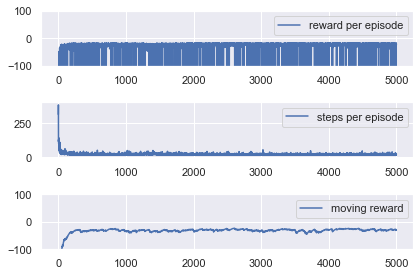

Reward sum : -24
Mean reward : -29.75
agent.epsilon : 0.2


In [17]:
exp_sarsa_agent = train_loop(env1,exp_sarsa_agent,episodes, expected_sarsa_params['epsilon_discount'], 100, exp_sarsa=True)

### Sarsa algorithm

In [55]:
sarsa_params = {'epsilon' : 0.1,
                'gamma' : 0.99, 
                'eta' : 0.1,
                'epsilon_discount' : False
               }

In [58]:
sarsa_agent = Sarsa(n_actions, n_states, sarsa_params['epsilon'], sarsa_params['gamma'], sarsa_params['eta'])

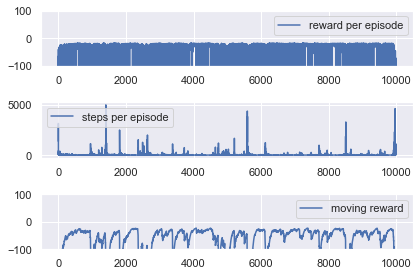

Reward sum : -198
Mean reward : -451.09
agent.epsilon : 0.1


In [59]:
sarsa_agent = train_loop(env1,sarsa_agent,10000, sarsa_params['epsilon_discount'])

### Sarsa(lambda) algortihm

In [31]:
lamba_sarsa_params = {'epsilon' : 0.1,
                'gamma' : 0.99, 
                'eta' : 0.25,
                'lambda_param' : 0.4,
                'epsilon_discount' : False
               }

In [32]:
lambda_sarsa_agent = LamdaSarsa(n_actions, n_states, lamba_sarsa_params['epsilon'], lamba_sarsa_params['gamma'], 
           lamba_sarsa_params['eta'], lamba_sarsa_params['lambda_param'])

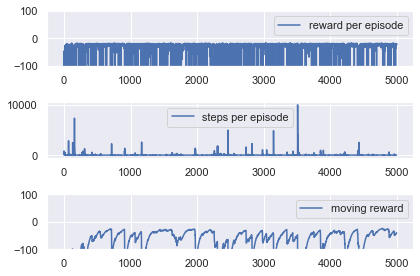

Reward sum : -19
Mean reward : -35.98
agent.epsilon : 0.1


In [33]:
lambda_sarsa_agent = train_loop(env1,lambda_sarsa_agent,episodes, lamba_sarsa_params['epsilon_discount'])

### Showing trajectories

In [27]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_action(yi * n_cols + xi)], end='')
        print()

In [74]:
exp_sarsa_agent.epsilon = 0
draw_policy(env,exp_sarsa_agent)

 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  >  >  >  ^  ^  >  >  >  ^  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [76]:
sarsa_agent.epsilon = 0
draw_policy(env,sarsa_agent)

 >  ^  <  >  ^  ^  >  v  ^  >  ^  > 
 <  <  >  ^  <  >  ^  >  <  ^  >  ^ 
 <  ^  ^  <  ^  ^  >  ^  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [75]:
lambda_sarsa_agent.epsilon = 0
draw_policy(env,lambda_sarsa_agent)

 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  >  >  ^  >  v 
 ^  ^  ^  ^  ^  ^  ^  >  ^  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
